###### Title: Substring matching with application to genomics/proteomics
###### Authors: Aiman Al Masoud - Lotito Davide Pio
###### Date: Feb 21, 2022
<img src="./images/logoUnipvST.jpg" width="50" height="50">

In [22]:
# imports 
from matplotlib import pyplot as plt
import pandas as pd

# 0) Context
The context in which the program operates is that of searching for particular strings (typically <em>genes</em>) within a larger text, the entire <em>genome</em>. Genomes are made of DNA, an extremely large molecule that looks like a long ladder. The genome is the set of all the genes of the organism and for most organisms made up entirely of DNA. This is the iconic DNA double helix. 

<img src="./images/dna1.png" width="300" height="300" style="display: block; margin-left: auto; margin-right: auto; width: 50%;">

DNA is read like a code. It is an organic polymer that contains genetic information of an organism. This code is made up of four types of chemical building blocks (nucleotides): adenine, thymine, cytosine, and guanine, abbreviated with the letters A, T, C, and G. The order of the letters in this code allows DNA to function in different ways. Inside the DNA are genes, which are small sections of DNA that code for specific traits. Actually, there are both genes that code and genes that do not code for proteins. 

### eukaryotic vs prokaryotic
An important division is made between eukaryotic cells and prokaryotic cells. Prokaryotes are single-celled organisms with a primitive cellular structure and simplified vital functioning compared to other living beings, for example bacteria such as Escherichia coli. Typically they have a single circular chromosome (DNA). While eukaryotic cells are more complex cells and have a DNA composed of one or more linear DNA chromosomes. Clearly an example is the human genome.

For our texts we have the genome of two bacteria and a bee:
* <em>Escherichia coli</em>: commonly found in the lower intestine of warm-blooded organisms, with a length of 5,000,000 nitrogenous base pairs
* <em>Nostoc punctiforme</em>: with a length of about 9,000,000 nitrogenous base pairs
* <em>Apis mellifera</em>: most common species of honey bees worldwide, with a total length of about 236,000,000 nitrogenous base pairs (16 chromosomes)

The genomes used for the tests are taken from <a href="https://www.ncbi.nlm.nih.gov/genbank/">https://www.ncbi.nlm.nih.gov/genbank/</a>.

# 1) Analysis of the Serial Algorithm


## String Matching

The algorithms for the search of substrings called pattern-string (of length $M$), in a larger string called text-string (of length $N$) are of fundamental importance, and have applications in many different fields. 

## The Rabin-Karp Algorithm

It is an algorithm that uses a rolling-hash function that allows it to achieve performances in the order of $O(M + N)$, with high probability. This is a completely different approach to brute-force, substring searching is based on hashing. 

### The operations  can be summarized in these few lines:
* Compute a hash function for the pattern
* Aearch for a match using the same hash function for each possible substring of characters $M$ of the text
* If we find a text substring with the same hash value as the pattern, check the match (Note: a matching hash does NOT imply a matching string)

## Role of the Rolling-Hash Function:

Be aware, however, that a direct implementation based on the above description would be much slower than a brute force search. Computing a hash function involving each character is probably much more expensive than just comparing characters. But Rabin and Karp showed that it is easy to compute hash functions for character substrings M in constant time (after some preprocessing). This leads to a search for substrings in linear time in practical situations, i.e. at the average performance (high probability) we have indicated.

## How does the Hash work?

The underlying theory is the following: we know that a string of length M corresponds to a base-$R$ number of $M$ digits ($R$: alphabet size). If I want to use a hash table of size $Q$ for keys of this type, we need a hash function to convert a base-$R$ $M$-digit number to an int value between $0$ and $Q-1$. Modular hashing can be a good idea:

$hash (x) = x\;mod\;Q$

Basically, we use $Q$, a random prime number, as large as possible.

<img src="./images/image1.png" width="300" style="display: block; margin-left: auto; margin-right: auto; width: 50%;">

As already mentioned, Rabin-Karp does not compute hashing on all strings of length $M$, to find the one with the same hash and then make the comparison. But we use the "mathematical trick" exploited by Rabin and Karp.
This "trick" leads, after preprocessing, to compute hashes in constant time. It exploits Horner's rule which states that it is possible to evaluate a polynomial of degree $N$ by carrying out only $N$ additions and $N$ multiplications. 


Example:

$ a_{2}* x^{2} + a_{1} * x + ... + a_{0} = (a^{2} * x + a_{1}) * x + a_{0} $


This identity holds true for modulo-arithmetics, the one we use for hashing, where the following applies:


$ (a_{2} * x^{2} + a_{1} * x + ... + a_{0})\;mod\;z = (((a_{2} * x + a_{1})\;mod\;z) * x + a_{0})\;mod\;z $


The Rabin-Karp method is based on efficiently computing the hash function $x_{i+1}$ for the position $i+1$ in the text, given its value for position $i$, $x_{i}$. Example:

$ x_{i}= t_{i} * RM^{-1} + t_{i}+1 * RM^{-2} + ... + t_{i} + M^{-1} * R0 $
$ x_{i+1} = t_{i+1} * RM + t_{i} * RM^{-1} + ... + t_{i} + M * R0 $

$ x_{i+1} = (x_{i} - t_{i} * RM^{-1}) * R + t_{i}+M $

We do not have to keep the values ​​of the numbers, only the values ​​of their remainder divided by $Q$. The algorithm is then used iteratively, calculating the hash of the next string, using that of the previous one as in the formula above.

<img src="./images/image2.png" width="300" style="display: block; margin-left: auto; margin-right: auto; width: 50%;">

Once we find a hash value for a substring of text of characters M that matches the hash value of the pattern, we do not test for match or collision. Matching requires M to be matched against the text string and this degrades performance. But if we make $Q$ very large, we make the probability of a collision extremely small. With a $Q$ value greater than $10^{20}$, we make the probability of a collision equal to $10^{-20}$.

This algorithm is a first and famous example of a <em>Monte Carlo</em> algorithm that has a guaranteed completion time but fails to provide a correct answer with a small probability.

In our implementation of the algorithm, we actually do check the pattern against the substring each time their hashes match. This is due to the fact that using a very large $Q$-value can lead to overflows, or slow down the execution. This means that once a match is found by our program, it’s guaranteed to be a match.

Our implementation of the Rabin-Karp algorithm is as follows. This is a review of the C++ code found in the following repository: <a href="https://github.com/avinashk442/String-matching-algorithms-and-applications">https://github.com/avinashk442/String-matching-algorithms-and-applications</a>.

    int search(char txt[] ,char pat[])
    {
        int M = strlen(pat);
        int N = strlen(txt);
        int cou = 0;
        int i, j;   // indexs
        int p = 0; // hash value for pattern
        int t = 0; // hash value for txt
        int h = 1; 
    
        // The value of h would be "pow(R, M-1)%q"
        // use for : do not use external library for pow
        // use %Q : avoid overflow
        for (i = 0; i < M-1; i++)
            h = (h*R)%Q;
    
        // Calculate the hash value of pattern and first window of text 
        // inizialization
        for (i = 0; i < M; i++)
        {
            p = (R*p + pat[i])%Q;
            t = (R*t + txt[i])%Q;
        }
    
        // Slide the pattern over text one by one
        for (i = 0; i <= N - M; i++)
        {   
            // Check the hash values of current window of text and pattern. 
            // If the hash values match then only check for characters on by one
            if ( p == t )
            {
                // Check for characters one by one
                for (j = 0; j < M; j++)
                {
                    if (txt[i+j] != pat[j])
                        break;
                }
                // if p == t and pat[0...M-1] = txt[i, i+1, ...i+M-1]
                if (j == M)
                    cou++;
            }
    
            // Calculate hash value for next window of text: remove
            // leading digit, add trailing digit
            if ( i < N-M )
            {
                t = (R*(t - txt[i]*h) + txt[i+M])%Q;
                // We might get negative value of t, converting it to positive
                // Rabin-Karp algorithm assumes that the hashes result are always nonnegative
                if (t < 0)
                    t = (t + Q);
            }
        }
        return cou;
    }

# 2) A Priori Study of Available Parallelism

## The Problem

As aforementioned, the Rabin-Karb algorithm for string-matching uses a rolling-hash to avoid having to repeat the computation of the hash for each window of text from scratch, and to achieve linear time complecity in the best case scenario.

<img src="http://img.sparknotes.com/figures/E/e06912cfeeac4cade7d4527506538c17/rabin1.gif" width="300"></img>

This effectively means that there's always a data-dependency between the current iteration and the one preceding it. In particular, this is an instance of a  **loop-carried dependence**: *statements in an iteration of a loop depend on statements in another iteration of the loop*. The presence of this dependence makes it hard to parallelize the algorithm itself: we cannot use the loop-unrolling technique. 

## Our Solution

The approach we resorted to, was to split the text into $N$ parts (or $N$ "sub-texts"), where $N$ is the number of slave processes, and to assign a sub-text to each slave process. 

#### Role of the Master Process

The master process starts out by reading the full text and the pattern to be searched in it. It splits the text into $N$ parts of equal length, and sends each part to a slave, togheter with the pattern, which is the same for everyone. 

Then the master waits for each slave process to return its result, ie: the number of occurences found in a slave's sub-text. 

#### Role of the Slave Processes

A slave probes the size of the incoming message, using <em>MPI_Probe</em> and <em>MPI_Get_count</em>. It then allocates enough space in memory to store its assigned sub-text and the pattern to be searched for. 

The message from the master is a single string that includes both the sub-text and the pattern, separated by a designated char (that obviously can't appear in the text). 

The slave runs Rabin-Karp on the sub-text and the pattern, calling back the master when it is done searching, and returning its result.

#### Working Hypothesis

Assuming that the subtext is much larger than the pattern, we can neglect the remainder of the int division between text size and number of slaves. 

##### For example:

* $ N = 7 $ (Number of slave processes, using N+1 cores).
* $ M = 1000 $ (Size of the pattern).
* $ T = 1000000 $ (Size of the full text).

$ T\;mod\;N = 1 << M $       

Hence it's not worth it, or even possible, to search for a pattern of size $M$ in a portion the text of size $ T mod N $.

### Calculating 'S' and 'P' for Amdahl's law equation

Assuming that the ratio of C-slocs to Asm-slocs is approximately constant throughout the codebase.

### Lines of C/C++ Code:

In [23]:
def count_lines(pathname):
    import re
    with open(pathname, "r") as f:
        source = f.read()
    source = source.split("\n") 
    source = [line for line in source if len(line.strip()) > 0 ]
    source = [re.sub("\\s+", "", line) for line in source]
    source = [line for line in source if line[:2] != '//'  ]
    return len(source)

In [24]:
# the rabin-karp part and roughly half of the main (slave).
parallelizable = count_lines("../src/headers/rabin_karp.h") +count_lines("../src/parallel/main.cpp")/2

# total
total = parallelizable + count_lines("../src/parallel/main.cpp")/2 + count_lines("../src/headers/read_file.h")

P = parallelizable/total
S = 1-P
print("The percentage of serial code is:", round(S, 2))
print("The percentage of parallel code is:", round(P, 2))
# S, P

The percentage of serial code is: 0.38
The percentage of parallel code is: 0.62


#### Applying Amdahl Law's Equation

In [25]:
speedup = lambda N, S, P : 1 / (S + P/N)

In [26]:
n_slaves = 3
f"With {n_slaves} slave cores, the expected speed-up is: {speedup(n_slaves, S, P)}"

'With 3 slave cores, the expected speed-up is: 1.703056768558952'

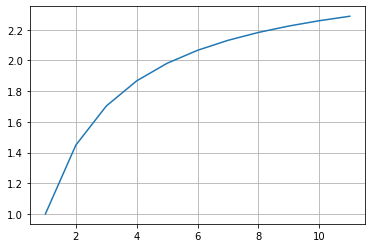

In [27]:
slaves = range(1, 12)
plt.grid()
plt.plot(slaves, list(map(lambda x: speedup(x, S, P), slaves)))

### With Assembly slocs
(Assuming ratio of C-slocs/Asm-slocs is NOT constant throughout the codebase).

#### Decompiling the executable and counting the lines of code used by each part of the program:

In [28]:
! mpic++ -g -O0 -fno-builtin ../src/parallel/main.cpp -o a.out
!  objdump -fsd --source a.out > dump.txt
! rm a.out
asm_code = ! cat dump.txt


##### Approx. Intervals from dump.txt (objump data):

In [29]:
dif = lambda a, b : abs(a-b) # distance between a and b 
master = dif( *[asm_code.index(x) for x in asm_code if "MASTER" in x])
slave = dif( *[asm_code.index(x) for x in asm_code if "SLAVE" in x])
search = dif( *[asm_code.index(x) for x in asm_code if "RABINKARP" in x])
read = dif( *[asm_code.index(x) for x in asm_code if "READFILE" in x])

tot = master+slave+search+read
P = (slave+search)/tot
S = 1 - P

print("The percentage of serial code is:", round(S, 2))
print("The percentage of parallel code is:", round(P, 2))


The percentage of serial code is: 0.49
The percentage of parallel code is: 0.51


#### Applying Amdahl Law's Equation

In [30]:
n_slaves = 3
f"With {n_slaves} slave cores, the expected speed-up is: {speedup(n_slaves, S, P)}"

'With 3 slave cores, the expected speed-up is: 1.5125'

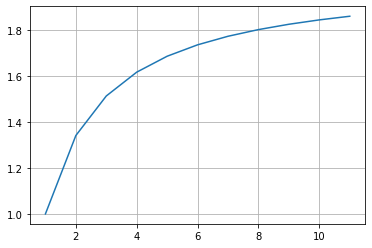

In [31]:
slaves = range(1, 12)
plt.grid()
plt.plot(slaves, list(map(lambda x: speedup(x, S, P), slaves)))

# 3) MPI parallel implementation

Here are the main parts of our parallel C ++ program using openMPI.

### Master side

Send the sub-text to the slaves

	for (int p = 1; p < size; ++p) {
			
		string subtxt = txt.substr(offset, payLoadSize);
		string message = string(subtxt)+SEPARATOR+string(pat)+"\0";
		retVal = MPI_Send(message.c_str(),  message.length() , MPI_CHAR, p, TAG, MPI_COMM_WORLD);
		offset+=payLoadSize;
	}

Waits for the slaves to finish and receives the value

	for (int p = 1; p < size; ++p){
		MPI_Recv(&result, 1, MPI_INT, p, TAG, MPI_COMM_WORLD, &status);
		results+=result;
	}

### Slave side

Probe for an incoming message from master. When probe returns, the status object has the size and other attributes of the incoming message.  

    MPI_Status status;
    MPI_Probe(0, TAG, MPI_COMM_WORLD, &status);
	
	int messageSize; //size of the incoming string
    MPI_Get_count(&status, MPI_CHAR, &messageSize);

So we can get the message size  and allocate the necessary memory for the salve to memorize it.

    int numBytes = sizeof(char)*(messageSize);
	char* buf = (char*)malloc(numBytes);

Then it receives the "message" from the master, splits the string in sub-text and pattern. Finally proceeds with the search.

    retVal = MPI_Recv(buf, messageSize, MPI_CHAR, 0, TAG, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

	text = strtok(buf, SEPARATOR);
	pattern = strtok(NULL, SEPARATOR);

    int result = search(text, pattern);

Finally, send the result to the master.

    retVal = MPI_Send(&result, 1, MPI_INT, 0, TAG, MPI_COMM_WORLD);


# 4) Testing and debugging

For our performance tests, both in terms of timing and memory, we used three techniques:
* <em>clock()</em>: a C++ function that returns the processor time consumed by the program, divided by CLOCKS_PER_SEC we obtain time in seconds
* <em>Valgrind framework</em>: in particular we used the tool <em>massif</em>, na heap profiler, used to check the memory usage of our program

The data-sets used for the tests are those already mentioned:
* <em>Escherichia coli</em>: with a lenght of about 5,000,000 nitrogenous base pairs
* <em>Nostoc punctiforme</em>: with a length of about 9,000,000 nitrogenous base pairs
* <em>Apis mellifera</em>: with a total length of about 23,6000,000 nitrogenous base pairs (16 chromosomes)

On which the search is made for a gene of variable size, but typically in the order of a thousand letters (nitrogenous bases).

Our tests for both performance and program debugging are <em>automated</em> via a Python script that tests the code with different numbers of cores, with different data-sets. In particular, with the same number of cores and data-sets, three tests are carried out, ie the search for three different genes located in non-contiguous positions. 

# 5) Performance and scalibility analysis

All testing, performance and scalability, was conducted on the Google Cloud Platform. In particular, we created the cluster according to the "light cluster" technique consisting of 7 machines (1 master and 6 slaves). Each with 2vCores and 8GB of memory. All machines are within the same geographic region.

<img src="./images/cluster8.png" width="300" style="display: block; margin-left: auto; margin-right: auto; width: 50%;">

In [32]:
df = pd.read_json("./testBigOne.txt")

In [33]:
df

,text_size,pattern_size,num_occurances,millisecs,genome,gene_index,num_cores,subtext_size
0,5594837,2463,1.0,58.257,e_coli,2,1,NaN
1,5594837,771,1.0,58.532,e_coli,40,1,NaN
2,5594837,699,1.0,58.766,e_coli,1234,1,NaN
3,5594837,2463,1.0,79.264,e_coli,2,2,5594837.0
4,5594837,771,1.0,78.910,e_coli,40,2,5594837.0
5,5594837,699,1.0,77.298,e_coli,1234,2,5594837.0
6,5594837,2463,1.0,42.495,e_coli,2,3,2797418.0
7,5594837,771,1.0,41.382,e_coli,40,3,2797418.0
8,5594837,699,1.0,42.084,e_coli,1234,3,2797418.0
9,5594837,2463,1.0,31.211,e_coli,2,4,1864945.0


### Analysis of the Execution Time

The following graph shows how the performance trend (execution time) varies according to the number of cores. In effect, we group our data by "num_cores" and show the mean. This data was taken through our automated test launched on a single machine, with 8 cores available.

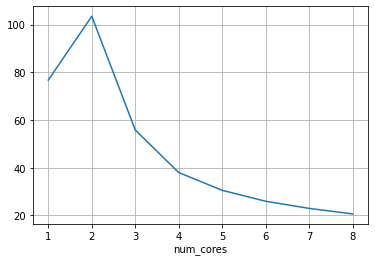

In [34]:
df.groupby( "num_cores" ).millisecs.mean().plot()
plt.grid()

The graph above shows that first of all that the serial algorithm is faster than that performed by 2 cores (1 master and one slave), an expected result. This is due to the overhead of openMPI and because there is actually only one slave doing the <em>search</em>. On the other hand, when the number of slaves grows, you can see how the performance improves gradually.

### Analysis of the speed-up

The next graph shows the performance trend, launching the automated test inside a machine with 8 cores, in terms of speed-up. That is the ratio between the execution time of the serial algorithm and the parallel one.

In [35]:
def serialMean(row):
    means = df[df.num_cores==1].groupby("genome").millisecs.mean()
    return means[row.genome]/row.millisecs

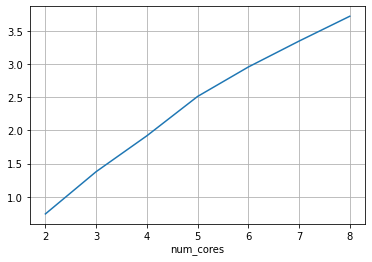

In [36]:
df["speedup"] = df.apply(serialMean,axis=1)
df[df.num_cores!=1].groupby("num_cores").speedup.mean().plot()
plt.grid()

We notice how the speed-up increases with the increase in the number of cores used for research. An expected result, indeed above our expectations compared to the analyzes made a priori.

### Scalability Analysis

This section shows the results related to the scalability analysis. Results made using the cluster on Google Colud Platform. We used 1 master with 6 slaves. Studied both strong and weak scalabilty.

In [37]:
df = pd.read_json("./test_cluster2.txt")
df = df.dropna().reset_index(drop=True)
df

,text_size,pattern_size,num_occurances,millisecs,genome,gene_index,num_cores,subtext_size
0,5594837.0,2463.0,1.0,94.719,e_coli,2,2,5594837.0
1,5594837.0,771.0,1.0,103.079,e_coli,40,2,5594837.0
2,5594837.0,699.0,1.0,104.005,e_coli,1234,2,5594837.0
3,5594837.0,2463.0,1.0,64.407,e_coli,2,3,2797418.0
4,5594837.0,771.0,1.0,68.707,e_coli,40,3,2797418.0
5,5594837.0,699.0,1.0,69.930,e_coli,1234,3,2797418.0
6,5594837.0,2463.0,1.0,64.513,e_coli,2,4,1864945.0
7,5594837.0,771.0,1.0,68.409,e_coli,40,4,1864945.0
8,5594837.0,699.0,1.0,62.671,e_coli,1234,4,1864945.0
9,5594837.0,2463.0,1.0,70.796,e_coli,2,5,1398709.0


#### Strong

As for strong scalability, what we expect is that by keeping the problem size the same. If the number of cores (machines / slaves) available, for example, doubles then the execution time is halved. Let's see what we found in the next graph. The result is shown using the bee genome, as it is more significant in this case.

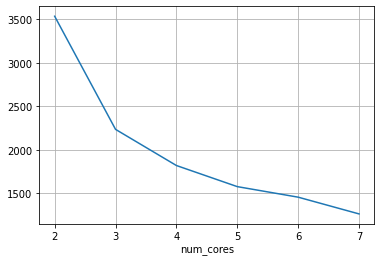

In [38]:
#df[df.genome=="nostoc"].groupby( "num_cores" ).millisecs.mean().plot()
#df[df.genome=="e_coli"].groupby( "num_cores" ).millisecs.mean().plot()
df[df.genome=="apis"].groupby( "num_cores" ).millisecs.mean().plot()
plt.grid()

What the graph shows is consistent with our expectations. For example, if we look with 4 cores (3 slaves) and with 7 cores (6 slaves), we notice how the execution time is approximately halved.

#### Weak

For the weak scalability, data always acquired on the cluster and by launching our automated test, what we expect is that if, for example, the size of the data-set grows by 1.5 times (ratio between E.coli and Nostoc genome) and the number of cores (machines / slaves) grows by 1.5 times. The execution time remains the same.

What the graph shows is ..

## Conlusion